In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import math
from numpy.random import multinomial, binomial
from scipy.stats import chi2

In [78]:
np.random.seed(0)

#  Data generation

In [3]:
#networks simulation
N = 100
D0 = np.random.randint(2,size=(N,N))
D0 = np.tril(D0) + np.tril(D0, -1).T
D1 = np.random.randint(2,size=(N,N))
D1 = np.tril(D1) + np.tril(D1, -1).T
for i in range(N):
    D0[i,i] = 0
    D1[i,i] = 0

In [4]:
M0 = np.sum(D0,axis=1)
G0 = np.linalg.solve(np.diag(M0),D0)

M1 = np.sum(D1,axis=1)
G1 = np.linalg.solve(np.diag(M1),D1)

In [5]:
F0 = (np.dot(D0,D0)>0).astype(np.int)
F1 = (np.dot(D1,D1)>0).astype(np.int)

In [6]:
#GPA simulation
gpa_0 = np.random.uniform(low= 0,high=4,size=N)
gpa_1 = np.random.uniform(low=0,high=4,size=N)

# 1. MLIM model

On fait la régression bayésienne, avec les a posteriori conjugués (inverse-$\chi^2(1)$, normale conditionnelle).

si on veut juste les means et vars, il suffit de les calculer les paramètres des posterior.

In [7]:
#priors 
#on a 4 coefficients beta sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution
a0 = 1 #coef of the inverse gamma
b0 = 1 #scaling coefficient of the inverse gamma

In [8]:
#construction des variables explicatives et variables cibles
Y = gpa_1
Ybar = G1.dot(Y)
X = gpa_0
Xbar = G1.dot(X)
features = np.column_stack((np.ones(len(Y)),Ybar,X,Xbar))

Les paramètres du modèle sont mis à jour selon les équations suivantes :
$$ Q_{n}=(\mathbf {X} ^{\rm {T}}\mathbf {X} + Q_{0}) $$
$$  \boldsymbol\mu_n=(\mathbf{X}^{\rm T}\mathbf{X}+ Q_0)^{-1} (Q_0\boldsymbol\mu_0+\mathbf{X}^{\rm T}\mathbf{y})  $$ 
$$ a_{n}=a_{0}+{\frac  {n}{2}} $$ 
$$ b_{n}=b_{0}+{\frac  {1}{2}}({\mathbf  {y}}^{{{\rm {T}}}}{\mathbf  {y}}+{\boldsymbol  \mu }_{0}^{{{\rm {T}}}}Q_{0}{\boldsymbol  \mu }_{0}-{\boldsymbol  \mu }_{n}^{{{\rm {T}}}}Q_{n}{\boldsymbol  \mu }_{n}) $$

In [9]:
#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
an = a0+len(Y)/2
bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))

In [10]:
#moyennes des lois normales a posteriori
mun

array([ 1.09576371,  0.78479078,  0.17112125, -0.51636236])

On obtient donc 
$$ \beta_0 = 1.46 , \beta_{\bar{Y}} = 0.42, \beta_x = 0.16, \beta_{\bar{x}} = -0.35 $$

In [11]:
#matrice de variance covariance
Qn

array([[101.        , 193.17298026, 198.45645215, 199.96862042],
       [193.17298026, 375.41000548, 379.30314175, 386.62398965],
       [198.45645215, 379.30314175, 545.17215733, 393.37329817],
       [199.96862042, 386.62398965, 393.37329817, 402.8029057 ]])

Pour le $\sigma^2$

In [12]:
bn/(an-1) #moyenne de l'inverse-gamma

1.193568716627484

In [13]:
bn**2/((an-1)**2*(an-2)) #variance de l'inverse gamma

0.029073597577791415

# 2. Exogenous network formation

$\alpha \sim \mathcal{N}(0,1)$ (chaque \alpha suit une loi normale de façon indépendante)

$\displaystyle{P(D_{1,ij} = 1|D_{0},X)  = (\frac{e^{\alpha_{0} + \alpha_{x}|Xi-Xj| + \alpha_{d}D_{0ij}+ \alpha_{f}F_{0ij}}}{1 + e^{\alpha_{0} + \alpha_{x}|Xi-Xj| + \alpha_{d}D_{0ij}+ \alpha_{f}F_{0ij}}})^2}$



In [14]:
#priors
alpha0 = np.random.randn(1)
alphax = np.random.randn(1)
alphad = np.random.randn(1)
alphaf = np.random.randn(1)

alpha = np.random.randn(4)

In [15]:
#feature engineering 
#we must create |Xi-Xj| for each (i,j) couple 
dist = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        value = np.abs(X[i]-X[j])
        dist[i][j] = value
        dist[j][i] = value

In [16]:
#matrix of utilities
U = np.exp(alpha[0]*np.ones((N,N))+alpha[1]*dist+alpha[2]*D0+alpha[3]*F0)

In [17]:
#We create a new D1 matrix based on the probability formula
D1_new = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        p = (U[i,j])/(1 + U[i,j])
        D1_new[i,j] = np.random.binomial(1,p**2)

In [51]:
def posterior(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(4):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [19]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0]
alpha_list = [alpha]
n_iter = 1000
for i in range(n_iter): 
    y = alpha + np.random.randn(4)
    ratio = posterior(y,D1,theta)/posterior(alpha,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alpha = b*y+(1-b)*alpha
    alpha_list.append(alpha)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


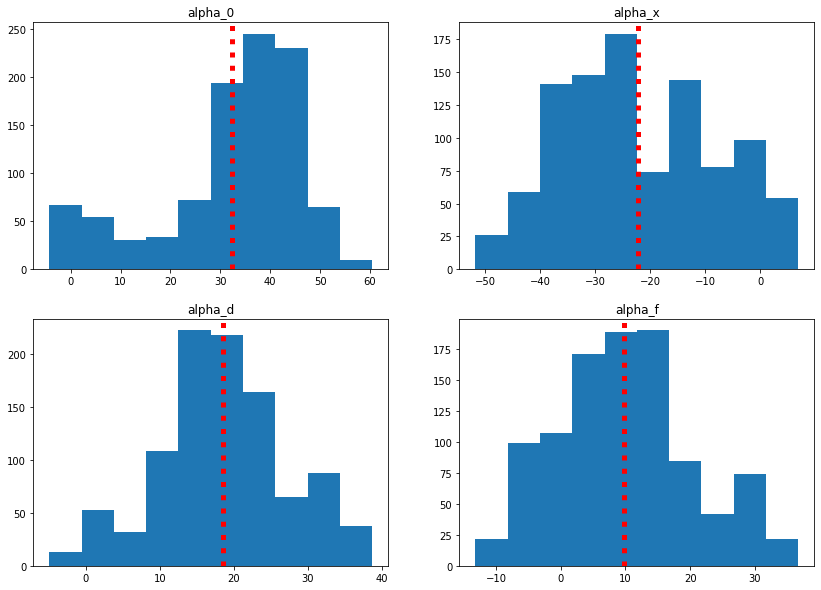

In [20]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [21]:
df = pd.DataFrame([],index=['a0','ax','ad','af'],columns = ['mean','std'])
for i in range(4):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,32.2766,14.3517
ax,-22.2041,13.7832
ad,18.5837,8.50401
af,9.783,10.4775


In [22]:
alphas = df['mean'].values

# 3. Endogenous network formation

In [23]:
betas = mun #results from 1st part
beta_cov_mat = Qn #from the first part
alphas = [np.mean(a)/1e10 for a in alpha_list] #results from 2nd part
alphas = np.zeros(4)
beta_xi = 0.1*np.random.randn(1) #normal with variance 0.01
alpha_xi = -1 + 0.1*np.random.randn(1) #N(-1,0.01)
xi = binomial(1,0.5,size=N)
xi[0] = 1
sigma2 = 2 #à corriger avec les résultats d'avant 

## update of $\xi_i$

In [24]:
#update of the xi_i
theta = [np.ones((N,N)),dist,D0,F0]
n_iter = 10
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alpha_xi*np.sum(D1[i,:].dot(xi))
        p1 += 2*alpha_xi*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

In [25]:
xi

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Update of $\beta$

In [26]:
def posterior_endo(b,bxi,sigma2,xi,a,axi,D):
    """
    compute log posterior then go exp 
    b is the beta vector [beta_0,beta_x,beta_ybar,beta_xbar]
    """
    N = D.shape[0]
    res = -0.5*np.linalg.norm(b[:-1]) #prior of beta
    res += -0.5*b[-1]**2/(0.01**2) #prior of beta xi
    res += np.sum([probas[i]*xi[i]+(1-probas[i])*(1-xi[i])]) #prior of xi
    res += chi2.ppf(sigma2,df=10) #prior of sigma2
    res += -0.5*np.linalg.norm(a) #prior of alpha
    res += -0.5*(axi+1)**2/(0.01**2) #prior of alpha_xi
    #compute pi(Y|b) 
    I = np.identity(N)
    A = np.linalg.inv(I-b[2]*G1)
    mean =  b[0]*np.ones(N)+b[1]*X+b[3]*G1.dot(X)+bxi*xi
    mean = A.dot(mean)
    var = sigma2*A.dot(A.T)
    inv_var = I-b[2]*G1
    res += -N/2*np.log(np.linalg.det(var))
    res += -0.5*(Y-mean).T.dot(inv_var).dot(Y-mean)
    
    return res

In [27]:
#update betas 
n_iter = 100
beta_list = [betas]
beta_xi_list = [0]
for i in range(n_iter):
    y = betas + (1/16)*Qn.dot(np.random.randn(4)) #normal centered on previous values with previous cov matrix
    yxi = 0.1*np.random.randn(1)[0]
    #computation of the beta posterior
    pi_prev = posterior_endo(beta_list[-1],beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    pi_suiv = posterior_endo(y,beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    #computation of ratio 
    ratio = pi_suiv/pi_prev
    inv_Qn = np.linalg.inv(Qn)
    ratio *= np.exp(-0.5*((beta_list[-1]-y).T.dot(inv_Qn).dot(beta_list[-1]-y)+100*(beta_xi_list[-1]-yxi)**2))
    #comparison with 1
    p_accept = min([1,ratio])
    #decision
    if binomial(1,p_accept):
        beta_list.append(y)
        beta_xi_list.append(yxi)
    else: 
        beta_list.append(beta_list[-1])
        beta_xi_list.append(beta_xi_list[-1])
            

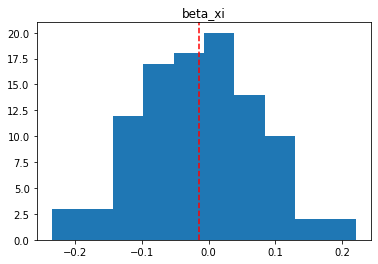

In [28]:
plt.hist(beta_xi_list)
plt.axvline(np.mean(beta_xi_list),ls='--',c='r')
plt.title('beta_xi')
plt.show()

In [29]:
df_beta = pd.DataFrame([],index=['beta0','betax','beta_ybar','beta_xbar','beta_xi'],columns = ['mean','std'])
for i in range(4):
    x1 = np.mean([b[i] for b in beta_list])
    x2 = np.std([b[i] for b in beta_list])
    df_beta.iloc[i] = [x1,x2]
df_beta.iloc[4] = [np.mean(beta_xi_list),np.std(beta_xi_list)]
df_beta

,mean,std
beta0,3.86822,20.4304
betax,6.08636,39.3788
beta_ybar,7.18938,45.8299
beta_xbar,5.0057,40.8333
beta_xi,-0.0149269,0.0883946


In [30]:
betas = df_beta['mean'].values

## Update $\sigma^2$

Gibbs sampling

In [37]:
sigma2_list = []
for k in range(100):
    invchi2 = chi2.ppf(np.random.rand(),df=10)
    I = np.identity(N)
    A = np.linalg.inv(I-betas[2]*G1)
    mu_y = betas[0]*np.ones(N)+betas[1]*X+betas[3]*G1.dot(X)+betas[4]*xi
    mu_y = A.dot(mu_y)
    var = np.matmul(I-betas[2]*G1,I-betas[2]*G1)
    tau2 =  (1/11)*(Y-mu_y).dot(var.dot(Y-mu_y))
    sigma2 = invchi2/(11*tau2)
    sigma2_list.append(sigma2)

In [39]:
sigma2 = np.mean(sigma2_list)
sigma2

6.542968218479678e-05

## Update $\alpha$

We use the same Metropolis-Hastings algorithm as previously with slight changes to take into account the $\xi$ variable.

In [46]:
alphas = np.append(alphas,alpha_xi)

In [49]:
def alpha_posterior_endo(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0,xi]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(5):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [50]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0,xi]
alpha_list = [alphas]
n_iter = 1000
for i in range(n_iter): 
    y = alphas + np.random.randn(5)
    ratio = posterior(y,D1,theta)/posterior(alphas,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alphas = b*y+(1-b)*alphas
    alpha_list.append(alphas)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


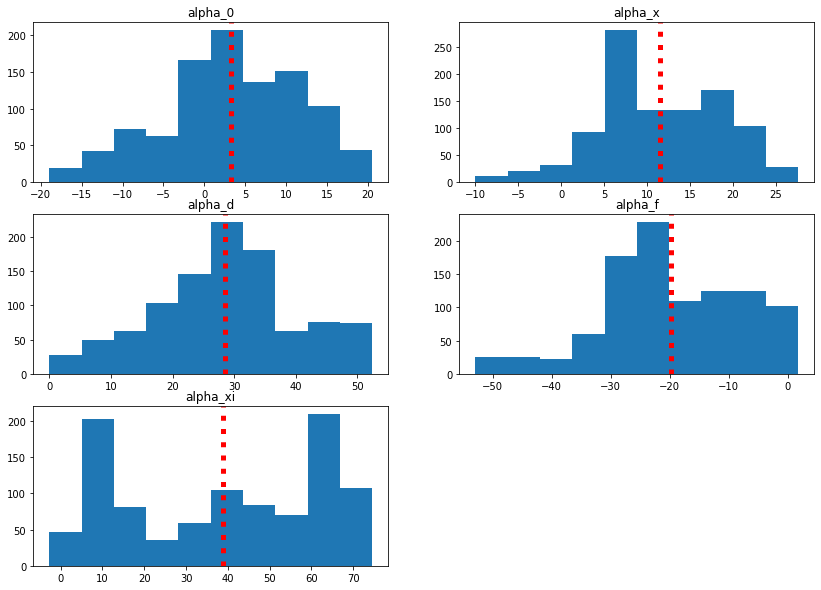

In [52]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f','alpha_xi']
for i in range(5):
    ax = fig.add_subplot(3,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [57]:
df = pd.DataFrame([],index=['a0','ax','ad','af','a_xi'],columns = ['mean','std'])
for i in range(5):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,3.30916,8.37169
ax,11.4835,7.09911
ad,28.5191,11.5068
af,-19.7622,11.7635
a_xi,38.7259,23.4175


In [58]:
alphas = df['mean'].values

## Update $\xi$

In [59]:
n_iter = 100
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alphas[4]*np.sum(D1[i,:].dot(xi))
        p1 += 2*alphas[4]*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


In [61]:
xi

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Nos valeurs n'ont pas forcément de sens: tout a été sélectionné au hasard

# 4. Heterogeneity in peer effects

On utilise une matrice de réseau à l'étpae 1 qui n'est plus symétrique (i ami de j n'implique pas j ami de i)  

In [68]:
D1 = np.random.randint(2,size=(N,N))
D0 = np.random.randint(2,size=(N,N))

Same as 1. with different networks and extended models

In [74]:
def heterogeneity(name):
    """
    réalise les estimations de la partie MLIM avec d'autres réseaux 
    parameters
    ----------
    name : définition du réseau utilisée
    
    returns
    -------
    df : pd.DataFrame contenant les means et vars pour beta et sigma2
    """
    
    if name=='lagged':
        DB = D0 * (1 - D1)
    elif name =='mutual':
        DB = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
    elif name=='fof': #friends of friends
        DM = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
        FM = (np.dot(DM,DM)>0).astype(np.int)
        DB = (1 - D1) * FM
    else: 
        raise ValueError(name + ' is not a correct network specification')
    #priors 
    #on a 6 coefficients beta sur lesquels travailler 
    mu0 = np.zeros(6) #mean of the conditional normal distribution 
    Q0 = np.diag(np.ones(6)) #var of the conditional normal distribution
    a0 = 1 #coef of the inverse gamma
    b0 = 1 #scaling coefficient of the inverse gamma

    #construction du réseau B
    MB = np.sum(DB,axis=1)
    GB = np.linalg.solve(np.diag(MB),DB)
    #construction des variables explicatives et variables cibles
    Y = gpa_1
    X = gpa_0
    YbarA = G1.dot(Y)
    XbarA = G1.dot(X)
    YbarB = GB.dot(Y)
    XbarB = GB.dot(X)
    features = np.column_stack((np.ones(len(Y)),X,YbarA,XbarA,YbarB,XbarB))

    #updating parameters: computing the posterior distribution parameters
    Qn = features.T.dot(features) + Q0
    mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
    an = a0+len(Y)/2
    bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))
    
    
    df = pd.DataFrame([],index=['beta0','betax','beta_ybarA','beta_xbarA','beta_ybarB','beta_xbarB','sigma2'],columns = ['mean','std'])
    for i in range(6):
        x1 = mun[i]
        x2 = np.sqrt(Qn[i,i])
        df.iloc[i] = [x1,x2]
    
    df.iloc[6] = [bn/(an-1),np.sqrt(bn**2/((an-1)**2*(an-2)))]
    print(df)
    
    return df  

In [75]:
df_lagged = heterogeneity('lagged')

                 mean       std
beta0        0.933953   10.0499
betax        0.167568   23.3489
beta_ybarA   0.633578   19.3755
beta_xbarA  -0.590605     20.07
beta_ybarB   0.403391   19.4335
beta_xbarB -0.0847675   19.9645
sigma2        1.18494  0.169278


In [76]:
df_mutual = heterogeneity('mutual')

                mean       std
beta0       0.660681   10.0499
betax       0.144145   23.3489
beta_ybarA  0.389346   19.3755
beta_xbarA  -0.78322     20.07
beta_ybarB  0.656368   19.2169
beta_xbarB  0.267122   20.0031
sigma2       1.17449  0.167784


In [77]:
df_fof = heterogeneity('fof')

                 mean       std
beta0        0.475671   10.0499
betax        0.141682   23.3489
beta_ybarA   0.243249   19.3755
beta_xbarA  -0.803678     20.07
beta_ybarB    1.10547   19.3516
beta_xbarB  0.0870701   19.8842
sigma2        1.14975  0.164251


# 5. Auto-regressive and moving average

## Auto-regressive models

In [78]:
#priors 
#on a 4 coefficients gamma sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution

#construction des variables explicatives et variables cibles
Y = gpa_1
X = gpa_0
GX = G1.dot(X)
GGX = G1.dot(GX)
features = np.column_stack((np.ones(len(Y)),X,GX,GGX))

#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))

In [81]:
df = pd.DataFrame([],index=['gamma0','gammaX','gamma1','gamma2'],columns = ['mean','std'])
for i in range(4):
    x1 = mun[i]
    x2 = np.sqrt(Qn[i,i])
    df.iloc[i] = [x1,x2]
df

,mean,std
gamma0,0.660042,10.0499
gammaX,0.123466,23.3489
gamma1,-0.742012,20.07
gamma2,1.2499,20.0428


In [88]:
bx = df['mean']['gammaX']
bybar = df['mean']['gamma2']/df['mean']['gamma1']
bxbar = df['mean']['gamma1'] - bx * bybar
b0 = (I - bybar*G1).dot(df['mean']['gamma0']*np.ones(N))[0]

In [90]:
df = pd.DataFrame([],index=['beta0','betaX','beta_xbar','beta_FIC'],columns = ['mean'])
df['mean']['beta0'] = b0
df['mean']['betaX'] = bx
df['mean']['beta_xbar'] = bxbar
df['mean']['beta_FIC'] = bybar

df

,mean
beta0,1.77187
betaX,0.123466
beta_xbar,-0.534036
beta_FIC,-1.68447


## Mobile average

# Application à une autre base

Consommation d'alcool hebdomadaire en unités d'alcool

In [165]:
n_clusters = 5
pop = 100
N = 100
cluster_attribution = np.random.randint(n_clusters,size=pop)
means1 = (4 - (1))*np.random.random_sample(n_clusters) + (1)
means2 = means1 + 0.05*np.random.randn(n_clusters)

In [166]:
prox = np.random.rand(N,N)
prox = np.tril(prox) + np.tril(prox, -1).T
prox*=0.05

In [171]:
norm = np.random.randn(pop,2)
X,Y = norm[:,0],norm[:,1]
for k in range(pop):
    i = cluster_attribution[k]
    Y[k] = means2[i]+ 0.4*Y[k]
    X[k] = means1[i]+ 0.3*X[k]

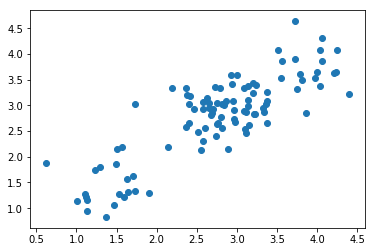

In [172]:
plt.scatter(X,Y)

In [173]:
N = pop
D0 = np.zeros((N,N))
D1 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        if cluster_attribution[i]==cluster_attribution[j]:
            proba = 0.2
        else: 
            proba = prox[cluster_attribution[i],cluster_attribution[j]]
        f0 = binomial(1,proba)
        f1 = binomial(1,proba)
        D0[i,j] = f0
        D0[j,i] = f0
        D1[i,j] = f1
        D1[j,i] = f1

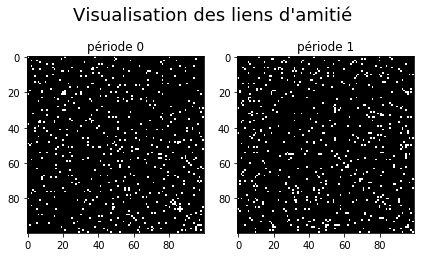

In [174]:
fig,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(D0,cmap='gray')
ax1.set_title('période 0')
ax2.imshow(D1,cmap='gray')
ax2.set_title('période 1')
fig.suptitle("Visualisation des liens d'amitié",fontsize=18)
plt.tight_layout()
plt.show()

Application du code à la nouvelle base

In [175]:
M0 = np.sum(D0,axis=1)
G0 = np.linalg.solve(np.diag(M0),D0)
M1 = np.sum(D1,axis=1)
G1 = np.linalg.solve(np.diag(M1),D1)
F0 = (np.dot(D0,D0)>0).astype(np.int)
F1 = (np.dot(D1,D1)>0).astype(np.int)

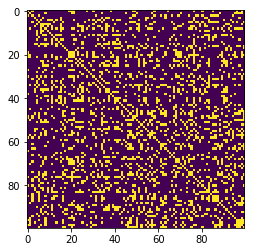

In [176]:
plt.imshow(F0)

## Statistiques descriptives

In [177]:
df = pd.DataFrame([],index=['Y','X',"nombre d'amis 1","nombre d'amis 2"],columns = ['mean','std','min','max'])
df.loc['Y'] = [np.mean(Y),np.std(Y),np.min(Y),np.max(Y)]
df.loc['X'] = [np.mean(X),np.std(X),np.min(X),np.max(X)]
nbamis1 = np.sum(D0,axis=1)
nbamis2 = np.sum(D1,axis=1)
df.loc["nombre d'amis 1"] = [np.mean(nbamis1),np.std(nbamis1),np.min(nbamis1),np.max(nbamis1)]
df.loc["nombre d'amis 2"] = [np.mean(nbamis2),np.std(nbamis2),np.min(nbamis2),np.max(nbamis2)]
df

,mean,std,min,max
Y,2.78078,0.817691,0.824779,4.64108
X,2.75183,0.859247,0.622824,4.39841
nombre d'amis 1,5.29,1.98643,1,11
nombre d'amis 2,5.67,2.29806,1,12


## Modèle LIM

In [178]:
#a priori
#on a 4 coefficients beta sur lesquels travailler 
mu0 = np.zeros(4) #moyenne de la gaussienne conditionnelle
Q0 = np.diag(np.ones(4)) #variance de la gaussienne conditionnelle
a0 = 1 #coefficient de l'inverse gamma
b0 = 1 #coefficient d'échelle de l'inverse gamma

In [179]:
#construction des variables explicatives et variables cibles
Ybar = G1.dot(Y)
Xbar = G1.dot(X)
features = np.column_stack((np.ones(len(Y)),Ybar,X,Xbar))

In [180]:
#mise à jour des paramètres: calcul des distributions a posteriori
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
invQn = np.linalg.solve(Qn,np.identity(4))
an = a0+len(Y)/2
bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))

In [181]:
#moyennes des lois normales a posteriori
df = pd.DataFrame([],index=['beta0','beta_ybar','beta_x','beta_xbar'],columns = ['mean','std'])
stds = [np.sqrt(invQn[i,i]) for i in range(len(Qn))]
df['mean'] = mun
df['std'] = stds
df

,mean,std
beta0,0.344423,0.443933
beta_ybar,0.032048,0.401612
beta_x,0.736788,0.153261
beta_xbar,0.116539,0.410999


In [182]:
#matrice de variance covariance
Qn

array([[101.        , 274.67077034, 275.18282266, 272.33029231],
       [274.67077034, 786.96336783, 785.64945071, 778.53772446],
       [275.18282266, 785.64945071, 832.0864378 , 783.09757038],
       [272.33029231, 778.53772446, 783.09757038, 776.88661995]])

In [183]:
print(f"Moyenne de sigma2: {bn/(an-1):.2f}")
print(f"Variance de sigma2: {bn**2/((an-1)**2*(an-2)):.2f}")

Moyenne de sigma2: 0.22
Variance de sigma2: 0.00


Pour les commentaires sur les valeurs, voir le rapport joint.

## Modèle exogène

In [184]:
#a priori 
alpha0 = np.random.randn(1)
alphax = np.random.randn(1)
alphad = np.random.randn(1)
alphaf = np.random.randn(1)
alpha = np.random.randn(4)

In [185]:
#feature engineering 
#we must create |Xi-Xj| for each (i,j) couple 
dist = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        value = np.abs(X[i]-X[j])
        dist[i][j] = value
        dist[j][i] = value

In [186]:
#matrix of utilities
U = np.exp(alpha[0]*np.ones((N,N))+alpha[1]*dist+alpha[2]*D0+alpha[3]*F0)

In [187]:
#We create a new D1 matrix based on the probability formula
D1_new = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        p = (U[i,j])/(1 + U[i,j])
        D1_new[i,j] = np.random.binomial(1,p**2)

In [188]:
def posterior(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(4):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [189]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0]
alpha_list = [alpha]
n_iter = 1000
for i in range(n_iter): 
    y = alpha + np.random.randn(4)
    ratio = posterior(y,D1,theta)/posterior(alpha,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alpha = b*y+(1-b)*alpha
    alpha_list.append(alpha)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


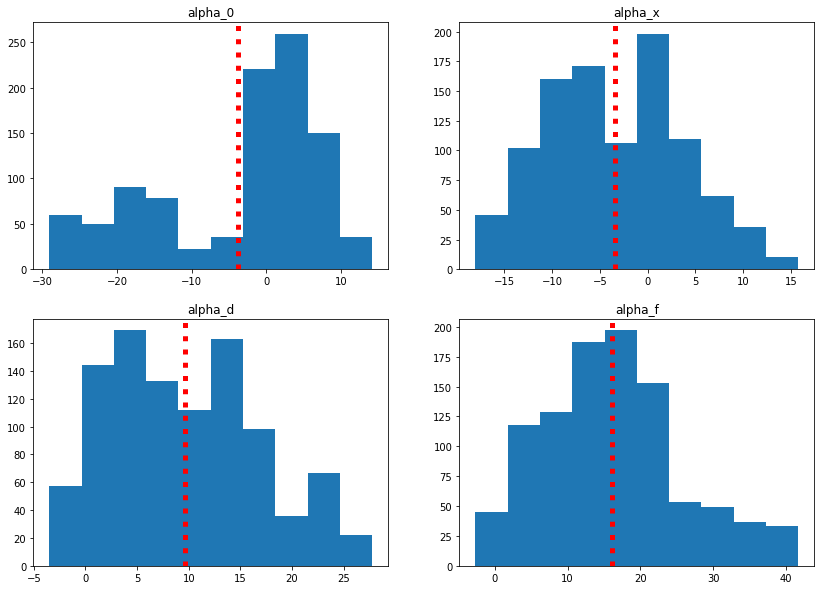

In [190]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [196]:
df = pd.DataFrame([],index=['a0','ax','ad','af'],columns = ['mean','std'])
for i in range(4):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,-3.73652,10.9439
ax,-3.42074,7.07823
ad,9.676,7.22795
af,16.124,9.50923


In [197]:
alphas = df['mean'].values

## Modèle endogène

In [198]:
betas = mun #results from 1st part
beta_cov_mat = Qn #from the first part
#alphas = [np.mean(a) for a in alpha_list] #results from 2nd part
#alphas = np.zeros(4)
beta_xi = 0.1*np.random.randn(1) #normal with variance 0.01
alpha_xi = -1 + 0.1*np.random.randn(1) #N(-1,0.01)
xi = binomial(1,0.5,size=N)
xi[0] = 1
sigma2 = 2 #à corriger avec les résultats d'avant 

## update of $\xi_i$

In [194]:
#update of the xi_i
theta = [np.ones((N,N)),dist,D0,F0]
n_iter = 10
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alpha_xi*np.sum(D1[i,:].dot(xi))
        p1 += 2*alpha_xi*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [199]:
xi

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

## Update of $\beta$

In [200]:
def posterior_endo(b,bxi,sigma2,xi,a,axi,D):
    """
    compute log posterior then go exp 
    b is the beta vector [beta_0,beta_x,beta_ybar,beta_xbar]
    """
    N = D.shape[0]
    res = -0.5*np.linalg.norm(b[:-1]) #prior of beta
    res += -0.5*b[-1]**2/(0.01**2) #prior of beta xi
    res += np.sum([probas[i]*xi[i]+(1-probas[i])*(1-xi[i])]) #prior of xi
    res += chi2.ppf(sigma2,df=10) #prior of sigma2
    res += -0.5*np.linalg.norm(a) #prior of alpha
    res += -0.5*(axi+1)**2/(0.01**2) #prior of alpha_xi
    #compute pi(Y|b) 
    I = np.identity(N)
    A = np.linalg.inv(I-b[2]*G1)
    mean =  b[0]*np.ones(N)+b[1]*X+b[3]*G1.dot(X)+bxi*xi
    mean = A.dot(mean)
    var = sigma2*A.dot(A.T)
    inv_var = I-b[2]*G1
    res += -N/2*np.log(np.linalg.det(var))
    res += -0.5*(Y-mean).T.dot(inv_var).dot(Y-mean)
    
    return res

In [201]:
#update betas 
n_iter = 100
beta_list = [betas]
beta_xi_list = [0]
for i in range(n_iter):
    y = betas + (1/16)*Qn.dot(np.random.randn(4)) #normal centered on previous values with previous cov matrix
    yxi = 0.1*np.random.randn(1)[0]
    #computation of the beta posterior
    pi_prev = posterior_endo(beta_list[-1],beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    pi_suiv = posterior_endo(y,beta_xi_list[-1],sigma2,xi,alphas,alpha_xi,D1)
    #computation of ratio 
    ratio = pi_suiv/pi_prev
    inv_Qn = np.linalg.inv(Qn)
    ratio *= np.exp(-0.5*((beta_list[-1]-y).T.dot(inv_Qn).dot(beta_list[-1]-y)+100*(beta_xi_list[-1]-yxi)**2))
    #comparison with 1
    p_accept = min([1,ratio])
    #decision
    if binomial(1,p_accept):
        beta_list.append(y)
        beta_xi_list.append(yxi)
    else: 
        beta_list.append(beta_list[-1])
        beta_xi_list.append(beta_xi_list[-1])
            

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


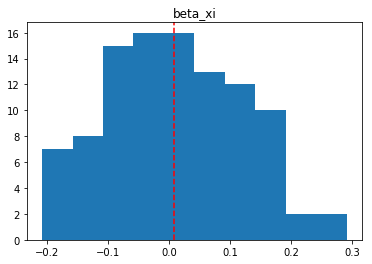

In [202]:
plt.hist(beta_xi_list)
plt.axvline(np.mean(beta_xi_list),ls='--',c='r')
plt.title('beta_xi')
plt.show()

In [203]:
df_beta = pd.DataFrame([],index=['beta0','betax','beta_ybar','beta_xbar','beta_xi'],columns = ['mean','std'])
for i in range(4):
    x1 = np.mean([b[i] for b in beta_list])
    x2 = np.std([b[i] for b in beta_list])
    df_beta.iloc[i] = [x1,x2]
df_beta.iloc[4] = [np.mean(beta_xi_list),np.std(beta_xi_list)]
df_beta

,mean,std
beta0,-1.13384,32.0484
betax,-4.138,91.4508
beta_ybar,-4.107,93.6724
beta_xbar,-4.09693,90.9635
beta_xi,0.00931237,0.110103


In [204]:
betas = df_beta['mean'].values

## Update $\sigma^2$

Gibbs sampling

In [205]:
sigma2_list = []
for k in range(100):
    invchi2 = chi2.ppf(np.random.rand(),df=10)
    I = np.identity(N)
    A = np.linalg.inv(I-betas[2]*G1)
    mu_y = betas[0]*np.ones(N)+betas[1]*X+betas[3]*G1.dot(X)+betas[4]*xi
    mu_y = A.dot(mu_y)
    var = np.matmul(I-betas[2]*G1,I-betas[2]*G1)
    tau2 =  (1/11)*(Y-mu_y).dot(var.dot(Y-mu_y))
    sigma2 = invchi2/(11*tau2)
    sigma2_list.append(sigma2)

In [206]:
sigma2 = np.mean(sigma2_list)
sigma2

5.312833301722812e-05

## Update $\alpha$

We use the same Metropolis-Hastings algorithm as previously with slight changes to take into account the $\xi$ variable.

In [207]:
alphas = np.append(alphas,alpha_xi)

In [208]:
def alpha_posterior_endo(a,x,theta):
    """
    parameters
    ----------
    a: array of alpha parameters
    x: D1 
    theta: array [np.ones,(|Xi-Xj|),D0,F0,xi]
    """
    N = x.shape[0]
    res = np.exp(-0.5*a.dot(a))**(N*(N-1)*0.5)
    for i in range(N):
        for j in range(i+1,N):
            #compute <alpha,theta>
            ps = 0
            for k in range(5):
                ps += a[k]*theta[k][i,j] 
            res *= np.exp(2*x[i,j]*ps)
    return res

In [209]:
#Metropolis Hastings with normal kernel 
theta = [np.ones((N,N)),dist,D0,F0,xi]
alpha_list = [alphas]
n_iter = 1000
for i in range(n_iter): 
    y = alphas + np.random.randn(5)
    ratio = posterior(y,D1,theta)/posterior(alphas,D1,theta)*1 #1 is the kernel ratio term 
    p_accept = min([1,ratio])
    b = binomial(1,p_accept)
    alphas = b*y+(1-b)*alphas
    alpha_list.append(alphas)

C:\Users\benoit\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


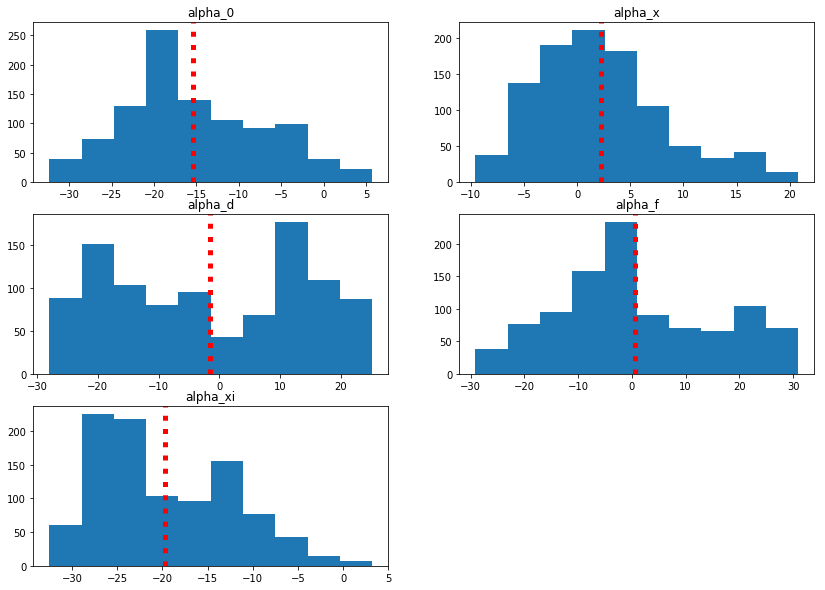

In [210]:
fig = plt.figure(figsize=(14,10))
titles = ['alpha_0','alpha_x','alpha_d','alpha_f','alpha_xi']
for i in range(5):
    ax = fig.add_subplot(3,2,i+1)
    alpha0 = [a[i] for a in alpha_list]
    ax.hist(alpha0)
    ax.set_title(titles[i])
    ax.axvline(np.mean(alpha0),ls='dotted',c='r',linewidth = 5)
plt.show()

In [211]:
df = pd.DataFrame([],index=['a0','ax','ad','af','a_xi'],columns = ['mean','std'])
for i in range(5):
    alpha0 = [a[i] for a in alpha_list]
    df.iloc[i,:] = [np.mean(alpha0),np.std(alpha0)]
df

,mean,std
a0,-15.3733,8.18314
ax,2.28888,6.07904
ad,-1.50293,15.6263
af,0.577468,14.6962
a_xi,-19.6951,7.43838


In [212]:
alphas = df['mean'].values

## Update $\xi$

In [213]:
n_iter = 100
for n in range(n_iter):
    probas = []
    for i in range(N):
        #compute binomial parameter
        p0 = 0
        p1 = 0
        for j in range(N):
            for k in range(4):
                p0 += 2*D1[i,j]*alphas[k]*theta[k][i,j]
            p1 += p0
        p0 += 2*alphas[4]*np.sum(D1[i,:].dot(xi))
        p1 += 2*alphas[4]*(N-np.sum(D1[i,:].dot(xi)))
        proba = 1/(1+np.exp(p1-p0))
        probas.append(proba)
        xi[i] = binomial(1,proba)

In [214]:
xi

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Nos valeurs n'ont pas forcément de sens: tout a été sélectionné au hasard

# 4. Heterogeneity in peer effects

On utilise une matrice de réseau à l'étpae 1 qui n'est plus symétrique (i ami de j n'implique pas j ami de i)  

In [215]:
N = pop
D0 = np.zeros((N,N))
D1 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        if cluster_attribution[i]==cluster_attribution[j]:
            proba = 0.9
        else: 
            proba = prox[cluster_attribution[i],cluster_attribution[j]]
        D0[i,j] = binomial(1,proba)
        D0[j,i] = binomial(1,proba)
        D1[i,j] = binomial(1,proba)
        D1[j,i] = binomial(1,proba)

Same as 1. with different networks and extended models

In [216]:
def heterogeneity(name):
    """
    réalise les estimations de la partie MLIM avec d'autres réseaux 
    parameters
    ----------
    name : définition du réseau utilisée
    
    returns
    -------
    df : pd.DataFrame contenant les means et vars pour beta et sigma2
    """
    
    if name=='lagged':
        DB = D0 * (1 - D1)
    elif name =='mutual':
        DB = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
    elif name=='fof': #friends of friends
        DM = np.asarray([[D1[i,j]==D1[j,i] for j in range(N)] for i in range(N)])
        FM = (np.dot(DM,DM)>0).astype(np.int)
        DB = (1 - D1) * FM
    else: 
        raise ValueError(name + ' is not a correct network specification')
    #priors 
    #on a 6 coefficients beta sur lesquels travailler 
    mu0 = np.zeros(6) #mean of the conditional normal distribution 
    Q0 = np.diag(np.ones(6)) #var of the conditional normal distribution
    a0 = 1 #coef of the inverse gamma
    b0 = 1 #scaling coefficient of the inverse gamma

    #construction du réseau B
    MB = np.sum(DB,axis=1)
    GB = np.linalg.solve(np.diag(MB),DB)
    #construction des variables explicatives et variables cibles
    Y = gpa_1
    X = gpa_0
    YbarA = G1.dot(Y)
    XbarA = G1.dot(X)
    YbarB = GB.dot(Y)
    XbarB = GB.dot(X)
    features = np.column_stack((np.ones(len(Y)),X,YbarA,XbarA,YbarB,XbarB))

    #updating parameters: computing the posterior distribution parameters
    Qn = features.T.dot(features) + Q0
    mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))
    an = a0+len(Y)/2
    bn = b0 + 0.5*(Y.dot(Y)+mu0.T.dot(Q0.dot(mu0))-mun.T.dot(Qn.dot(mun)))
    
    
    df = pd.DataFrame([],index=['beta0','betax','beta_ybarA','beta_xbarA','beta_ybarB','beta_xbarB','sigma2'],columns = ['mean','std'])
    for i in range(6):
        x1 = mun[i]
        x2 = np.sqrt(Qn[i,i])
        df.iloc[i] = [x1,x2]
    
    df.iloc[6] = [bn/(an-1),np.sqrt(bn**2/((an-1)**2*(an-2)))]
    print(df)
    
    return df  

In [217]:
df_lagged = heterogeneity('lagged')

LinAlgError: Singular matrix

In [ ]:
df_mutual = heterogeneity('mutual')

In [ ]:
df_fof = heterogeneity('fof')

# 5. Auto-regressive and moving average

## Auto-regressive models

In [ ]:
#priors 
#on a 4 coefficients gamma sur lesquels travailler 
mu0 = np.zeros(4) #mean of the conditional normal distribution 
Q0 = np.diag(np.ones(4)) #var of the conditional normal distribution

#construction des variables explicatives et variables cibles
Y = gpa_1
X = gpa_0
GX = G1.dot(X)
GGX = G1.dot(GX)
features = np.column_stack((np.ones(len(Y)),X,GX,GGX))

#updating parameters: computing the posterior distribution parameters
Qn = features.T.dot(features) + Q0
mun = np.linalg.solve(Qn,Q0.dot(mu0)+features.T.dot(Y))

In [ ]:
df = pd.DataFrame([],index=['gamma0','gammaX','gamma1','gamma2'],columns = ['mean','std'])
for i in range(4):
    x1 = mun[i]
    x2 = np.sqrt(Qn[i,i])
    df.iloc[i] = [x1,x2]
df

In [ ]:
bx = df['mean']['gammaX']
bybar = df['mean']['gamma2']/df['mean']['gamma1']
bxbar = df['mean']['gamma1'] - bx * bybar
b0 = (I - bybar*G1).dot(df['mean']['gamma0']*np.ones(N))[0]

In [ ]:
df = pd.DataFrame([],index=['beta0','betaX','beta_xbar','beta_FIC'],columns = ['mean'])
df['mean']['beta0'] = b0
df['mean']['betaX'] = bx
df['mean']['beta_xbar'] = bxbar
df['mean']['beta_FIC'] = bybar

df

Le $\hat{\beta}_{FIC}$ est négatif puisqu'on n'a pas modélisé la dépendance interclusters en fonction de la variable Y (et donc on ne retrouve aucun impact rationnel)

## Moving average